# Lab 5

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/giswqs/geog-312/blob/main/book/labs/lab_05.ipynb)

## Objective:

This lab introduces you to essential GIS raster operations using Python's rasterio and matplotlib libraries. By the end of this lab, you will have learned to:

- Read and explore raster data files.
- Visualize and manipulate single-band and multi-band rasters.
- Perform basic raster operations such as clipping, band math, and reprojection.
- Work with Digital Elevation Models (DEMs) and multispectral satellite imagery.

## Required Libraries:
Make sure you have the following libraries installed:

In [ ]:
 %pip install rasterio matplotlib numpy

import rasterio
import rasterio.plot
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import fiona
import rasterio.mask
from rasterio.windows import Window
from rasterio.transform import from_bounds

258937.33s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


**Sample datasets**

- Singlg-band image (DEM): https://github.com/opengeos/datasets/releases/download/raster/dem_90m.tif
- Multispectral image (Landsat): https://github.com/opengeos/datasets/releases/download/raster/cog.tif

**Exercise 1: Reading and Exploring Raster Data**

1. Open the single-band DEM image using `rasterio`.
2. Retrieve and print the raster metadata, including the CRS, resolution, bounds, number of bands, and data types.
3. Display the raster’s width, height, and pixel data types to understand the grid dimensions and data structure.

In [ ]:
raster_path = ('https://github.com/opengeos/datasets/releases/download/raster/dem_90m.tif')

src = rasterio.open(raster_path)
print(src)

<open DatasetReader name='https://github.com/opengeos/datasets/releases/download/raster/dem_90m.tif' mode='r'>


In [ ]:
src.meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': None,
 'width': 4269,
 'height': 3113,
 'count': 1,
 'crs': CRS.from_epsg(3857),
 'transform': Affine(90.0, 0.0, -13442488.3428,
        0.0, -89.99579177642138, 4668371.5775)}

In [ ]:
src.res

(90.0, 89.99579177642138)

In [ ]:
src.bounds

BoundingBox(left=-13442488.3428, bottom=4388214.6777, right=-13058278.3428, top=4668371.5775)

**Exercise 2: Visualizing and Manipulating Raster Bands**

1. Visualize the single-band DEM using a custom colormap (e.g., cmap='terrain').
2. Open the multispectral image and visualize the first band using a suitable colormap.
3. Combine multiple bands from the multispectral image (e.g., Red, Green, and Blue) and stack them to create an RGB composite image.

<Axes: title={'center': 'Digital Elevation Model (DEM)'}>

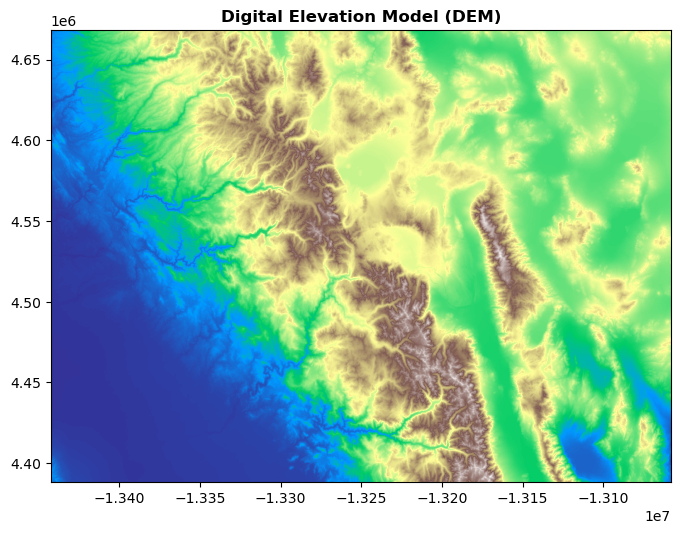

In [ ]:
f, ax = plt.subplots(figsize = (8,8))
rasterio.plot.show(src, cmap='terrain', ax=ax, title = 'Digital Elevation Model (DEM)')

In [ ]:
multispectral_path = ('https://github.com/opengeos/datasets/releases/download/raster/cog.tif')

landsat = rasterio.open(multispectral_path)

In [ ]:
landsat.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 343,
 'height': 206,
 'count': 4,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(8.983152841195215e-05, 0.0, 6.860074498707138,
        0.0, -8.983152841195215e-05, 53.41634207654228)}

In [ ]:
landsat.tags()

{'AREA_OR_POINT': 'Area',
 'TIFFTAG_RESOLUTIONUNIT': '1 (unitless)',
 'TIFFTAG_XRESOLUTION': '1',
 'TIFFTAG_YRESOLUTION': '1'}

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


<Axes: >

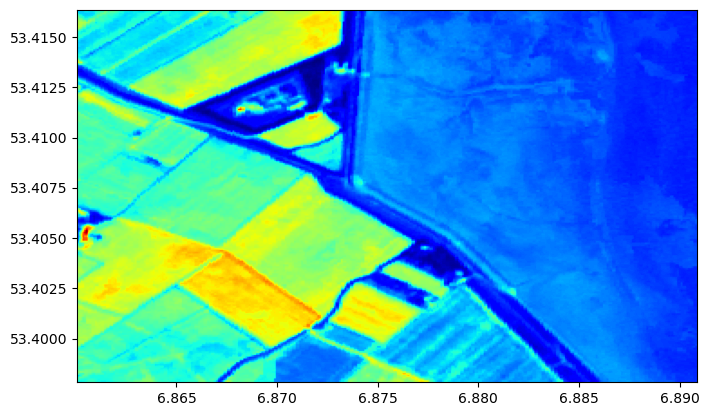

In [ ]:
f, ax = plt.subplots(figsize = (8,8))
rasterio.plot.show((landsat,1), cmap='jet', ax=ax)

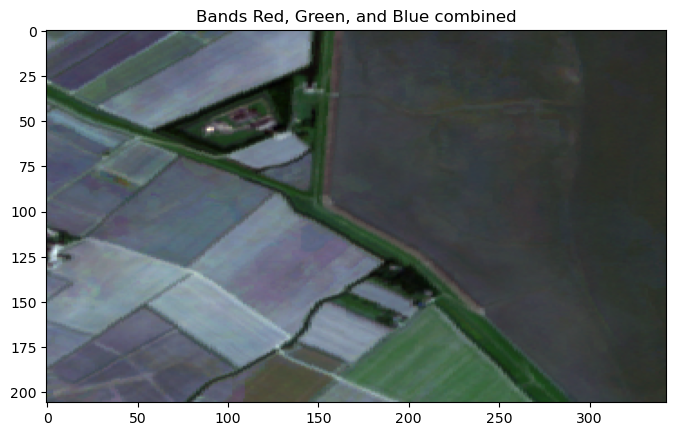

In [ ]:
blue_band = landsat.read(1)
green_band = landsat.read(2)
red_band = landsat.read(3)

def min_max_normalize(band):
    return (band - band.min()) / (band.max() - band.min())

blue_band = min_max_normalize(landsat.read(1))
green_band = min_max_normalize(landsat.read(2))
red_band = min_max_normalize(landsat.read(3))

rgb = np.dstack((red_band, green_band, blue_band)).clip(0, 1)


plt.figure(figsize=(8, 8))
plt.imshow(rgb, vmin=0, vmax=1)
plt.title("Bands Red, Green, and Blue combined")
plt.show()

**Exercise 3: Raster Clipping with Array Indexing**

1. Open the multispectral image and clip a geographic subset using array indexing (specifying row and column ranges).
2. Visualize the clipped portion of the image using matplotlib to ensure the subset is correct.
3. Save the clipped raster subset to a new file named `clipped_multispectral.tif`.

In [ ]:
multispectral_path = ('https://github.com/opengeos/datasets/releases/download/raster/cog.tif')

with rasterio.open(multispectral_path) as dataset:
    data = dataset.read()

In [ ]:
subset = data[:, 25:75, 50:150]

def min_max_normalize(band):
    return (band - band.min()) / (band.max() - band.min())

clipped_blue_band = min_max_normalize(subset[0])
clipped_green_band = min_max_normalize(subset[1])
clipped_red_band = min_max_normalize(subset[2])

rgb_clipped = np.dstack((clipped_red_band, clipped_green_band, clipped_blue_band)).clip(0, 1)




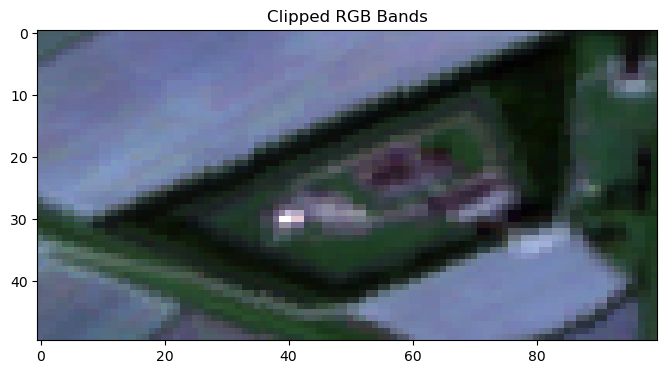

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(rgb_clipped, vmin=0, vmax=1)
plt.title("Clipped RGB Bands")
plt.show()

In [ ]:
with rasterio.open(
    "clip.tif",
    "w",
    driver="GTiff",
    height=subset.shape[1],
    width=subset.shape[2],
    count=subset.shape[0],
    dtype=subset.dtype,
    crs=landsat.crs,
    transform=new_transform,
    compress="lzw",
) as dst:
    dst.write(subset)

**Exercise 4: Calculating NDWI (Band Math)**

1. Open the multispectral image and extract the Green and Near-Infrared (NIR) bands.
2. Compute the Normalized Difference Water Index ([NDWI](https://en.wikipedia.org/wiki/Normalized_difference_water_index)) using the formula:

    NDWI= (Green - NIR) / (Green + NIR)

3. Visualize the NDWI result using a water-friendly colormap (e.g., cmap='Blues') to highlight water bodies.
4. Save the resulting NDWI image as a new raster file named ndwi.tif.

In [ ]:
multispectral_path = ('https://github.com/opengeos/datasets/releases/download/raster/cog.tif')

with rasterio.open(multispectral_path) as dataset:
    blue_band = dataset.read(1)
    green_band = dataset.read(2)
    red_band = dataset.read(3)
    nir_band = dataset.read(4)

In [ ]:
ndwi = (green_band - nir_band)/(green_band + nir_band)

<Axes: title={'center': 'NDWI)'}>

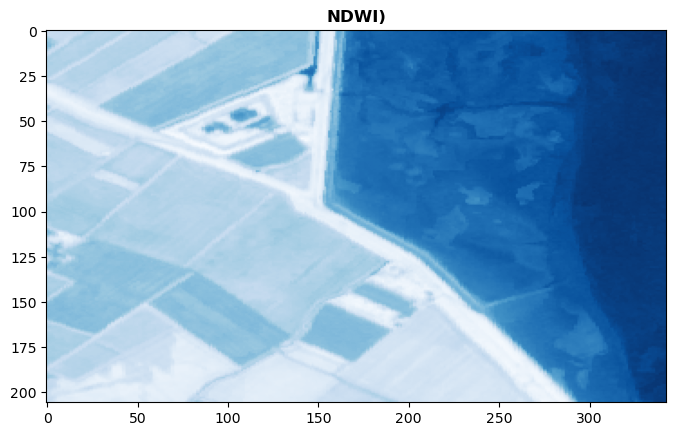

In [ ]:
f, ax = plt.subplots(figsize = (8,8))
rasterio.plot.show(ndwi, cmap='Blues', ax=ax, title = 'NDWI)')

In [ ]:
with rasterio.open(
    "ndwi.tif",
    "w",
    driver="GTiff",
    height=subset.shape[1],
    width=subset.shape[2],
    count=subset.shape[0],
    dtype=subset.dtype,
    crs=dataset.crs,
    transform=new_transform,
    compress="lzw",
) as dst:
    dst.write(subset)

**Exercise 5: Reprojecting Raster Data**

1. Reproject the single-band DEM raster from its original CRS to EPSG:4326 (WGS 84) using the `rasterio.warp.reproject` function.
2. Save the reprojected raster to a new GeoTIFF file named `reprojected_dem.tif`.
3. Visualize both the original and reprojected DEM datasets to compare how the reprojection affects the spatial coverage and resolution.

In [ ]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

raster_path = raster_path
dst_crs = "EPSG:4326"
output_reprojected_path = "reprojected_dem.tif"

with rasterio.open(raster_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)

    profile = src.profile
    profile.update(crs=dst_crs, transform=transform, width=width, height=height)

    with rasterio.open(output_reprojected_path, "w", **profile) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest,
            )

print(f"Reprojected raster saved at {output_reprojected_path}")

Reprojected raster saved at reprojected_dem.tif


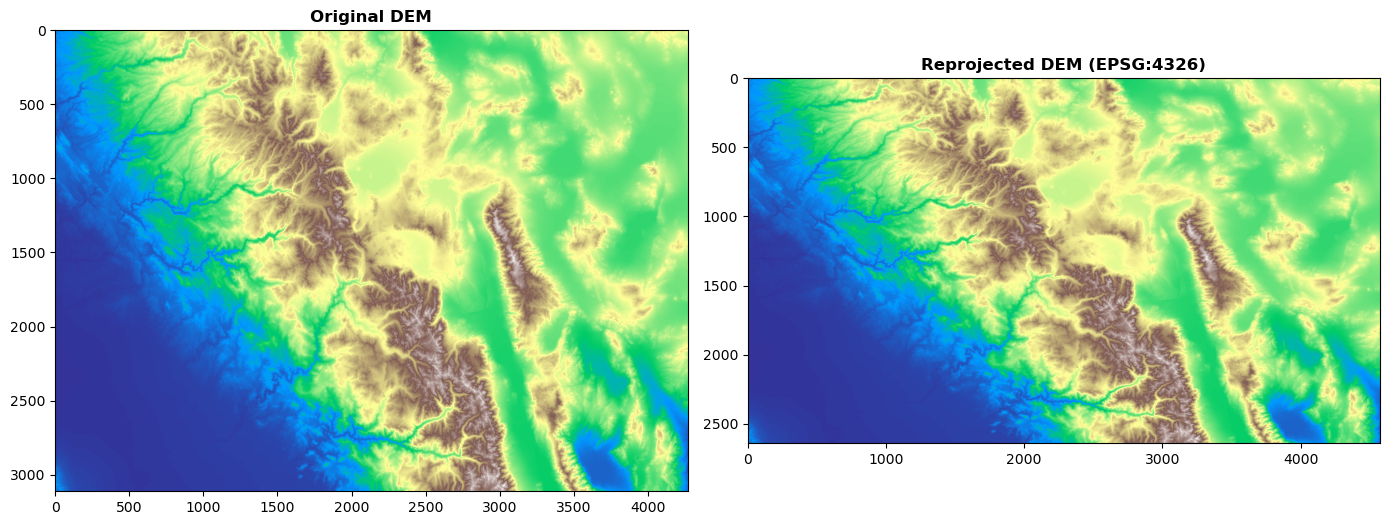

In [ ]:
with rasterio.open(raster_path) as src_original, rasterio.open(output_reprojected_path) as src_reprojected:
    # Read the first band of each raster
    original_dem = src_original.read(1)
    reprojected_dem = src_reprojected.read(1)

    # Set up the figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

    # Plot the original DEM
    rasterio.plot.show(original_dem, ax=ax1, title="Original DEM", cmap="terrain")

    # Plot the reprojected DEM
    rasterio.plot.show(reprojected_dem, ax=ax2, title="Reprojected DEM (EPSG:4326)", cmap="terrain")

    # Display the figure
    plt.tight_layout()
    plt.show()